In [2]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset, get_dataset_split_names, DatasetDict
from tqdm import tqdm

sns.set_color_codes("colorblind")
sns.set_theme(style="darkgrid")
sns.set_context("talk")
tqdm.pandas()

# set font to times new roman for plots
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

/Users/kyle/miniconda3/envs/memorization/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Datasets

In [88]:
split_sample_size = None
label_title_padding = 10
study_pile = False
RECITATION_THRESHOLD = 10

In [4]:
memories_path = "usvsnsp/generation-semantic-filters"
intermediate_path = "usvsnsp/generation-semantic-intermediate-filters"
memories_dataset = DatasetDict()
pile_dataset = DatasetDict()
splits = [split for split in get_dataset_split_names(memories_path) if "deduped" in split] + get_dataset_split_names(intermediate_path)
splits = [split for split in splits if "deduped" in split]
print(splits)

['pile_deduped_1.4b', 'memories_deduped_410m', 'memories_deduped_1.4b', 'memories_deduped_6.9b', 'memories_deduped_1b', 'pile_deduped_410m', 'pile_deduped_2.8b', 'pile_deduped_160m', 'memories_deduped_12b', 'pile_deduped_6.9b', 'pile_deduped_1b', 'memories_deduped_70m', 'memories_deduped_2.8b', 'pile_deduped_12b', 'memories_deduped_160m', 'pile_deduped_70m', 'memories_deduped_12b.43000', 'memories_deduped_12b.103000', 'memories_deduped_12b.83000', 'memories_deduped_12b.63000', 'memories_deduped_12b.123000', 'memories_deduped_12b.23000']


In [5]:
print("Loading datasets...")
print(f"Split sample size: {split_sample_size}")

for split in tqdm(splits):
    model = split.split("_")[-1]
    checkpoint = int(split.split(".")[-1]) if split.split(".")[-1][1].isnumeric() else 143000
    formatted_split_name = split.replace("memories_", "").replace("deduped_", "deduped.").replace("pile_", "")
    dataset_path = memories_path if checkpoint == 143000 else intermediate_path
    if "memories" in split: 
        # continue # Don't load memories since they're unnecessary for the first part of the analysis
        memories_dataset[formatted_split_name] = load_dataset(dataset_path, split=f"{split}[:{split_sample_size}]" if split_sample_size else split)
    else:
        continue
        pile_dataset[formatted_split_name] = load_dataset(dataset_path, split=f"{split}[:{split_sample_size}]" if split_sample_size else split)

display(memories_dataset)
display(pile_dataset)

Loading datasets...
Split sample size: None


100%|██████████| 22/22 [06:08<00:00, 16.77s/it]


DatasetDict({
    deduped.410m: Dataset({
        features: ['sequence_id', 'tokens', 'text', 'is_incrementing', 'is_repeating', 'sequence_duplicates', 'max_frequency', 'avg_frequency', 'min_frequency', 'median_frequency', 'p25_frequency', 'p75_frequency', 'frequencies', 'nl_scores', '0_8_snowclones', '0_9_snowclones', '0_8_templates', '0_9_templates', 'huffman_coding_length', 'memorization_score', 'index', 'loss', 'prompt_perplexity', 'generation_perplexity', 'sequence_perplexity'],
        num_rows: 811040
    })
    deduped.1.4b: Dataset({
        features: ['sequence_id', 'tokens', 'text', 'is_incrementing', 'is_repeating', 'sequence_duplicates', 'max_frequency', 'avg_frequency', 'min_frequency', 'median_frequency', 'p25_frequency', 'p75_frequency', 'frequencies', 'nl_scores', '0_8_snowclones', '0_9_snowclones', '0_8_templates', '0_9_templates', 'huffman_coding_length', 'memorization_score', 'index', 'loss', 'prompt_perplexity', 'generation_perplexity', 'sequence_perplexity'],
    

DatasetDict({
    
})

In [6]:
split_to_param_count = {
    "70m": 70000000,
    "160m": 160000000,
    "410m": 410000000,
    "1b": 1000000000,
    "1.4b": 1400000000,
    "2.8b": 2800000000,
    "6.9b": 6900000000,
    "12b": 12000000000,
}

In [12]:
def get_frame_from_split(dataset, split_name, is_pile_sample):
    current_frame = dataset[split].to_pandas()
    current_frame.drop(columns=columns_to_drop, inplace=True)
    checkpoint = int(split.split(".")[-1]) if split.split(".")[-1][1].isnumeric() and len(split.split(".")) != 2 else "Final"
    current_frame["Checkpoint"] = checkpoint
    current_frame["TrainingPercentage"] = 1 if checkpoint == "Final" else checkpoint / 143000
    model = split.split("deduped")[-1][1:] if checkpoint == "Final" else split.split(".")[-2]
    current_frame["Model"] = model
    current_frame["Param Count"] = split_to_param_count[current_frame["Model"].iloc[0]]
    current_frame["Deduped"] = "deduped" in split
    current_frame["Memorized"] = current_frame["memorization_score"] >= 1
    current_frame["IsPileSample"] = is_pile_sample
    return current_frame


columns_to_drop = ["frequencies", "tokens", "text"]
combined_dataframe = None
for split in tqdm(memories_dataset, desc="Loading Memories"):
    current_frame = get_frame_from_split(memories_dataset, split, False)
    if combined_dataframe is None:
        combined_dataframe = current_frame
    else:
        combined_dataframe = pd.concat([combined_dataframe, current_frame])

for split in tqdm(pile_dataset, desc="Loading Pile"):
    current_frame = get_frame_from_split(pile_dataset, split, True)
    combined_dataframe = pd.concat([combined_dataframe, current_frame])

combined_dataframe = combined_dataframe.sort_values("Param Count")
# display(combined_dataframe.shape)
# display(combined_dataframe.columns)
combined_dataframe

Loading Memories: 100%|██████████| 14/14 [00:11<00:00,  1.20it/s]
Loading Pile: 0it [00:00, ?it/s]


,sequence_id,is_incrementing,is_repeating,sequence_duplicates,max_frequency,avg_frequency,min_frequency,median_frequency,p25_frequency,p75_frequency,...,prompt_perplexity,generation_perplexity,sequence_perplexity,Checkpoint,TrainingPercentage,Model,Param Count,Deduped,Memorized,IsPileSample
311692,76369286,True,False,3,2965935634,9.619414e+08,1466086,26718143.5,3396213,2965935634,...,1.762004,1.028962,1.813036,Final,1.000000,70m,70000000,True,True,False
274304,101528653,False,False,126590,11740996961,2.183443e+09,2535454,397855078.0,24463239,1480613645,...,2.405067,1.001652,2.409041,Final,1.000000,70m,70000000,True,True,False
274303,101488489,False,False,12551,11740996961,2.955296e+09,605886,223388936.0,16400100,4201626736,...,2.173179,1.022547,2.222178,Final,1.000000,70m,70000000,True,True,False
274302,101355445,False,False,39601,11740996961,1.373194e+09,1033836,87048161.0,10406762,365616254,...,3.974078,1.012878,4.025258,Final,1.000000,70m,70000000,True,True,False
274301,101319862,False,False,40819,11740996961,3.075328e+09,1317065,573756779.0,12931579,4201626736,...,1.956711,1.012603,1.981370,Final,1.000000,70m,70000000,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325534,43193238,False,False,609181,11740996961,2.319468e+09,1612787,24613500.5,5114476,939268059,...,NaN,NaN,NaN,43000,0.300699,12b,12000000000,True,True,False
325533,43187425,False,False,226,11740996961,2.506770e+09,344343,108487617.0,5756465,1480613645,...,NaN,NaN,NaN,43000,0.300699,12b,12000000000,True,True,False
325532,43165692,False,False,3504,11740996961,1.040303e+09,351874,171363758.0,7462193,304221700,...,NaN,NaN,NaN,43000,0.300699,12b,12000000000,True,True,False
325542,43328930,False,False,6731,11740996961,1.400083e+09,711305,90651872.0,11201675,816247750,...,NaN,NaN,NaN,43000,0.300699,12b,12000000000,True,True,False


## Assign Examples to Taxonomy

In [89]:
def get_category(row):
    if row["Memorized"] == False:
        return "Not Memorized"
    if row["sequence_duplicates"] >= RECITATION_THRESHOLD:
        return "Recitation"
    if row["is_incrementing"] or row["is_repeating"]:
        return "Reconstruction"

    return "Recollection"

combined_dataframe["category"] = combined_dataframe.progress_apply(lambda row: get_category(row), axis=1)
combined_dataframe.value_counts(["Model", "Checkpoint", "category"])

100%|██████████| 13510441/13510441 [00:39<00:00, 345137.43it/s]


Model  Checkpoint  category      
12b    Final       Recitation        1521554
6.9b   Final       Recitation        1379503
12b    123000      Recitation        1271509
2.8b   Final       Recitation        1114324
12b    103000      Recitation         972908
1.4b   Final       Recitation         868737
1b     Final       Recitation         860603
12b    83000       Recitation         692617
410m   Final       Recitation         677656
160m   Final       Recitation         488998
12b    63000       Recitation         477775
70m    Final       Recitation         356982
12b    Final       Recollection       321445
       43000       Recitation         294235
6.9b   Final       Recollection       273262
12b    123000      Recollection       268342
2.8b   Final       Recollection       214053
12b    103000      Recollection       202754
1.4b   Final       Recollection       154990
1b     Final       Recollection       147248
12b    83000       Recollection       143741
       23000       Re

## Plot Graphs

### Figure: Count and Memories by Taxonomy Across Time and Scale

In [90]:
combined_memories_dataframe = combined_dataframe[combined_dataframe["IsPileSample"] == False]
combined_memories_dataframe

,sequence_id,is_incrementing,is_repeating,sequence_duplicates,max_frequency,avg_frequency,min_frequency,median_frequency,p25_frequency,p75_frequency,...,generation_perplexity,sequence_perplexity,Checkpoint,TrainingPercentage,Model,Param Count,Deduped,Memorized,IsPileSample,category
311692,76369286,True,False,3,2965935634,9.619414e+08,1466086,26718143.5,3396213,2965935634,...,1.028962,1.813036,Final,1.000000,70m,70000000,True,True,False,Reconstruction
274304,101528653,False,False,126590,11740996961,2.183443e+09,2535454,397855078.0,24463239,1480613645,...,1.001652,2.409041,Final,1.000000,70m,70000000,True,True,False,Recitation
274303,101488489,False,False,12551,11740996961,2.955296e+09,605886,223388936.0,16400100,4201626736,...,1.022547,2.222178,Final,1.000000,70m,70000000,True,True,False,Recitation
274302,101355445,False,False,39601,11740996961,1.373194e+09,1033836,87048161.0,10406762,365616254,...,1.012878,4.025258,Final,1.000000,70m,70000000,True,True,False,Recitation
274301,101319862,False,False,40819,11740996961,3.075328e+09,1317065,573756779.0,12931579,4201626736,...,1.012603,1.981370,Final,1.000000,70m,70000000,True,True,False,Recitation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325534,43193238,False,False,609181,11740996961,2.319468e+09,1612787,24613500.5,5114476,939268059,...,NaN,NaN,43000,0.300699,12b,12000000000,True,True,False,Recitation
325533,43187425,False,False,226,11740996961,2.506770e+09,344343,108487617.0,5756465,1480613645,...,NaN,NaN,43000,0.300699,12b,12000000000,True,True,False,Recitation
325532,43165692,False,False,3504,11740996961,1.040303e+09,351874,171363758.0,7462193,304221700,...,NaN,NaN,43000,0.300699,12b,12000000000,True,True,False,Recitation
325542,43328930,False,False,6731,11740996961,1.400083e+09,711305,90651872.0,11201675,816247750,...,NaN,NaN,43000,0.300699,12b,12000000000,True,True,False,Recitation


In [91]:
# Create plot for data across 
counts_frame_scale = combined_memories_dataframe[combined_memories_dataframe["Checkpoint"] == "Final"].value_counts(["Param Count", "category"]).unstack().reindex(split_to_param_count.values())
counts_frame_scale.to_csv(f"final_checkpoint_counts_recitation={RECITATION_THRESHOLD}.csv")
display(counts_frame_scale)

intermediate_frame = combined_memories_dataframe[combined_memories_dataframe["Model"] == "12b"]
sorted_checkpoints = sorted(sorted(intermediate_frame["TrainingPercentage"].unique(), key=lambda x: int(x)))

counts_frame_time = intermediate_frame.value_counts(["TrainingPercentage", "category"]).unstack().reindex(sorted_checkpoints)
counts_frame_time.to_csv(f"intermediate_checkpoint_counts_recitation={RECITATION_THRESHOLD}.csv")
display(counts_frame_time)

category,Recitation,Recollection,Reconstruction
Param Count,,,
70000000,356982,38351,16115
160000000,488998,70805,21397
410000000,677656,109520,23864
1000000000,860603,147248,25021
1400000000,868737,154990,24377
2800000000,1114324,214053,26839
6900000000,1379503,273262,27531
12000000000,1521554,321445,28217


category,Recitation,Recollection,Reconstruction
TrainingPercentage,,,
0.160839,134747,24659,4012
0.300699,294235,57131,7497
0.440559,477775,95574,11718
0.580420,692617,143741,15710
0.720280,972908,202754,19916
0.860140,1271509,268342,24204
1.000000,1521554,321445,28217


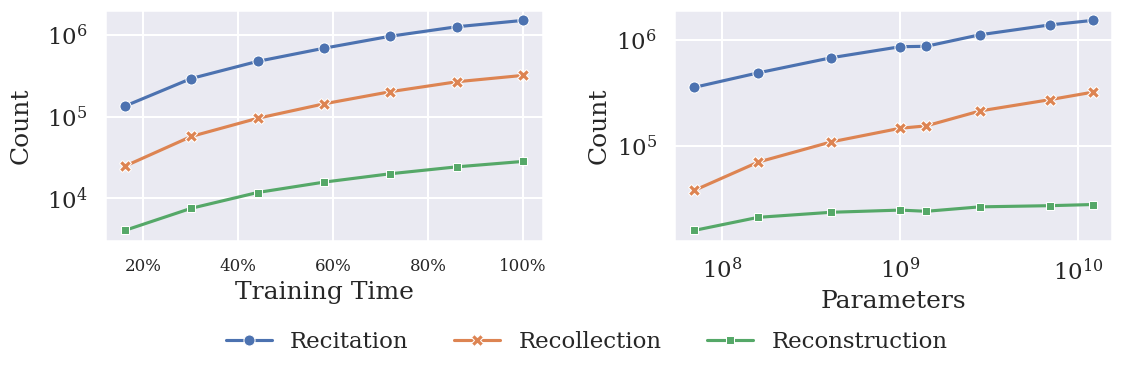

In [92]:
from matplotlib.ticker import PercentFormatter

fig, axes = plt.subplots(1, 2, figsize=(13, 3))

# set figure 1
# first figure is a line plot of the counts of each category for across intermediate checkpoints

sns.lineplot(ax=axes[0], data=counts_frame_time, dashes=False, markers=True, markersize=8)

# rotate x axis labels
# axes[0].tick_params(axis='x', rotation=20)

# Set x axix label to "Training Time"
axes[0].set_xlabel("Training Time")

# make x labels smaller
axes[0].tick_params(axis='x', labelsize=12)

# the x axis values are between 0 and 1. Set the x axis to be a percentage
axes[0].xaxis.set_major_formatter(PercentFormatter(1))

# Add y label for Count
axes[0].set_ylabel("Count", labelpad=label_title_padding)

# add padding for labels
fig.subplots_adjust(wspace=0.2)

# make x and y axis log scale
axes[0].set_yscale("log")

# # have a common legend for both plots centered below the figure. No legend box
axes[0].legend(loc='upper center', bbox_to_anchor=(1.1, -0.3), ncol=4, frameon=False)

# set figure 2
# the second figure is a line plot of the counts of each category across parameter count

sns.lineplot(ax=axes[1], data=counts_frame_scale, dashes=False, markers=True, markersize=8)

# make x and y axis log scale
axes[1].set_xscale("log")
axes[1].set_yscale("log")

# Set x label to "Parameters"
axes[1].set_xlabel("Parameters")

# Add y label for Count
axes[1].set_ylabel("Count")

# remove legend
axes[1].legend().remove()

# add padding for labels
fig.subplots_adjust(wspace=0.30)

fig.savefig(f"figures/categories_counts_across_time+scale_recitation={RECITATION_THRESHOLD}.pdf", bbox_inches="tight")



### Figure: Percents and Memories by Taxonomy Across Time and Scale

In [93]:
counts_frame = combined_memories_dataframe.value_counts(["Param Count", "category"]).unstack().reindex(split_to_param_count.values())
display(counts_frame)

category,Recitation,Recollection,Reconstruction
Param Count,,,
70000000,356982,38351,16115
160000000,488998,70805,21397
410000000,677656,109520,23864
1000000000,860603,147248,25021
1400000000,868737,154990,24377
2800000000,1114324,214053,26839
6900000000,1379503,273262,27531
12000000000,5365345,1113646,111274


In [94]:

all_percents_time = []
for checkpoint in tqdm(sorted_checkpoints):
    model_examples = combined_memories_dataframe[combined_memories_dataframe["TrainingPercentage"] == checkpoint]
    model_percents = model_examples.value_counts("category", normalize=True).to_dict()
    for category in model_percents:
        all_percents_time.append({
            "TrainingPercentage": checkpoint,
            "category": category,
            "percent": model_percents[category],
        })

percents_frame_time = pd.DataFrame(all_percents_time).pivot(index="TrainingPercentage", columns="category", values="percent").reindex(sorted_checkpoints)
percents_frame_time.index = [f"{int(percent * 100)}%" for percent in percents_frame_time.index]
percents_frame_time.to_csv(f"percents_frame_time_recitation={RECITATION_THRESHOLD}.csv")
display(percents_frame_time)

100%|██████████| 7/7 [00:01<00:00,  6.67it/s]


category,Recitation,Recollection,Reconstruction
16%,0.824554,0.150895,0.024551
30%,0.819909,0.159200,0.020891
44%,0.816616,0.163356,0.020028
58%,0.812866,0.168697,0.018437
72%,0.813755,0.169587,0.016658
86%,0.812957,0.171568,0.015475
100%,0.826758,0.151247,0.021994


In [95]:
all_percents_scale = []
for param_count in tqdm(split_to_param_count.values()):
    model_examples = combined_memories_dataframe[combined_memories_dataframe["Param Count"] == param_count]
    model_percents = model_examples.value_counts("category", normalize=True).to_dict()
    for category in model_percents:
        all_percents_scale.append({
            "Model": model_examples["Model"].unique()[0],
            "Param Count": param_count,
            "category": category,
            "percent": model_percents[category],
        })

percents_frame_scale = pd.DataFrame(all_percents_scale).pivot(index="Model", columns="category", values="percent").reindex(split_to_param_count.keys())
percents_frame_scale.to_csv(f"percents_frame_scale_recitation={RECITATION_THRESHOLD}.csv")
display(percents_frame_scale)

100%|██████████| 8/8 [00:01<00:00,  4.61it/s]


category,Recitation,Recollection,Reconstruction
Model,,,
70m,0.867624,0.093210,0.039167
160m,0.841359,0.121826,0.036815
410m,0.835540,0.135036,0.029424
1b,0.833214,0.142562,0.024225
1.4b,0.828865,0.147877,0.023258
2.8b,0.822248,0.157948,0.019804
6.9b,0.820988,0.162627,0.016385
12b,0.814132,0.168983,0.016885


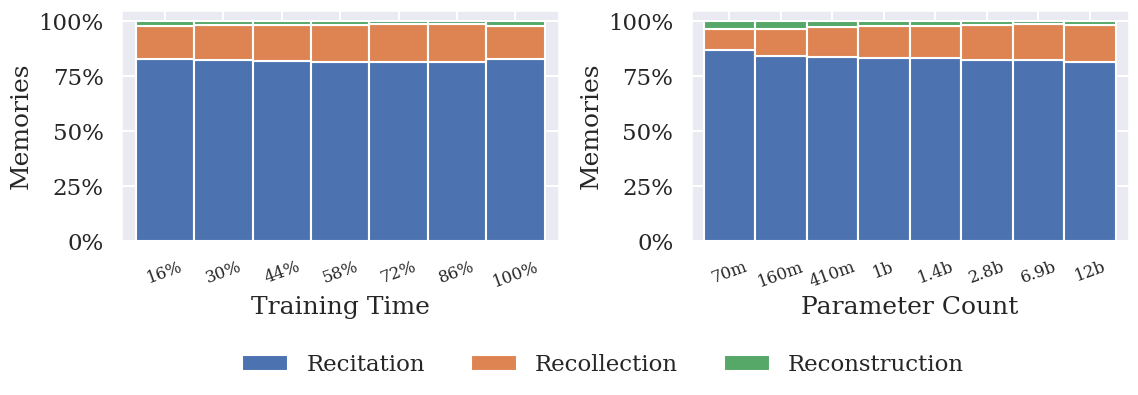

In [96]:
fig, axes = plt.subplots(1, 2, figsize=(13, 3))
plots = [
    (percents_frame_time, axes[0]),
    (percents_frame_scale, axes[1])
]

for idx, (data, ax) in enumerate(plots):
    data.plot.bar(
        stacked=True,
        ax=ax,
        rot=0,
        width=1,
        ylabel="Memories",
    )

    if idx == 0:
        ax.set_xlabel("Training Time")
    else:
        ax.set_xlabel("Parameter Count")
    
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}%".format(int(x * 100))))
    ax.tick_params(axis='x', rotation=20, labelsize=12)
    ax.get_legend().remove()

# Adjusting subplot parameters
fig.subplots_adjust(wspace=0.30)

# Common legend configuration
axes[0].legend(loc='upper center', bbox_to_anchor=(1.1, -0.4), ncol=4, frameon=False)

# align x axis labels
fig.align_xlabels()

# Save the figure
fig.savefig(f"figures/categories_percents_across_time+scale_recitation={RECITATION_THRESHOLD}.pdf", bbox_inches="tight")


## Figure: Combined Counts + Percents Plot

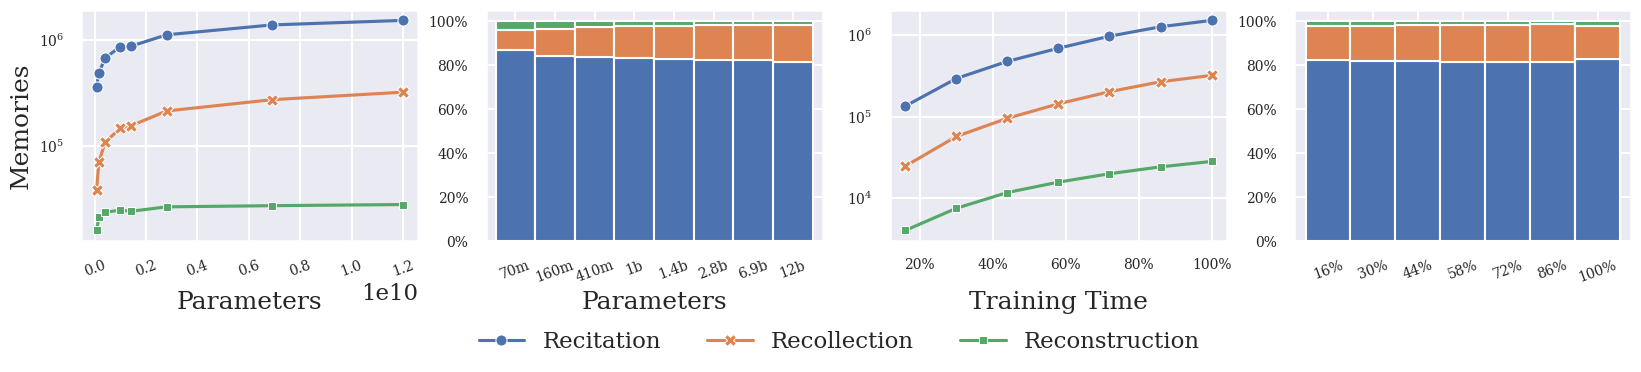

In [97]:
# Single row with four plots. Plot ordering is counts across scale, percents across scale, counts across time, percents across time
fig, axes = plt.subplots(1, 4, figsize=(20, 3))

# set figure 1
sns.lineplot(ax=axes[0], data=counts_frame_scale, dashes=False, markers=True, markersize=8)
axes[0].tick_params(axis='x', rotation=20, labelsize=10)
axes[0].set_yscale("log")
axes[0].tick_params(axis='y', labelsize=10)
axes[0].set_ylabel("Memories")
axes[0].set_xlabel("Parameters")
axes[0].legend(loc='upper center', bbox_to_anchor=(2.25, -0.3), ncol=4, frameon=False)

# set figure 2
percents_frame_scale.plot.bar(
    stacked=True,
    ax=axes[1],
    rot=0,
    width=1,
)
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}%".format(int(x * 100))))
axes[1].tick_params(axis='x', rotation=20, labelsize=10)
axes[1].tick_params(axis='y', labelsize=10)
axes[1].set_xlabel("Parameters")
axes[1].get_legend().remove()

# set figure 3
sns.lineplot(ax=axes[2], data=counts_frame_time, dashes=False, markers=True, markersize=8)
axes[2].set_yscale("log")
axes[2].tick_params(axis='x', labelsize=10)
axes[2].tick_params(axis='y', labelsize=10)
axes[2].set_xlabel("Training Time")
axes[2].xaxis.set_major_formatter(PercentFormatter(1))
axes[2].legend().remove()

# set figure 4
percents_frame_time.plot.bar(
    stacked=True,
    ax=axes[3],
    rot=0,
    width=1,
)
axes[3].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}%".format(int(x * 100))))
axes[3].tick_params(axis='x', rotation=20, labelsize=10)
axes[3].tick_params(axis='y', labelsize=10)
axes[3].get_legend().remove()

# make all the x labels have the same height
fig.align_xlabels()

# Save the figure
fig.savefig(f"figures/categories_counts_percents_across_time+scale_recitation={RECITATION_THRESHOLD}.pdf", bbox_inches="tight")